## Modelos de Regresión para predecir valores de una casa & modelación de data no estructurada
#### Autor: Andres Ochoa Arango 

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [206]:
#Librerias 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import scipy.stats as st
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2,f_regression, mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

### Modelación Data Estructurada
#### Importación de los datos

En esta primera parte se evidencia la estructura de los datos. En este caso, se tiene información de residencias en arrendamiento con algunas características relevantes. El objetivo principal es crear un modelo que pueda predecir el precio de las viviendas. En una primera mirada, se puede deducir que el tipo de metodología a implementar se basa en un modelo de regresión supervisado.

In [207]:
#Funciones utilizadas
def Nulos(df):
    for i in df.columns: 
        print('Col: {} / Nans: {} / Tipo de dato: {}'.format(i, df[i].isnull().sum(), df[i].dtype))

def IQR(df, col): 
    #Función para la eliminación de datos atípicos
    Q1 = np.percentile(df[col], 25)
    Q3 = np.percentile(df[col], 75)
    IQR = Q3 - Q1
    
    upper_bound = df[col] >= (Q3+1.5*IQR)
    lower_bound = df[col] <= (Q1-1.5*IQR)
    
    upper_points = np.where(upper_bound)
    df.drop(upper_points[0], inplace=True)
    df.reset_index(inplace = True, drop = True)

In [208]:
#Base de datos 
train = pd.read_csv('bd_train.csv')
test = pd.read_csv('bd_test.csv', sep = ',')

Primera mirada de las bases de datos. La información que se utilizara para el entrenamiento del modelo es de la base de datos "train" y para la entrega del ejercicio se evaluara el modelo con la base de datos "test". En este caso, la base de datos de entrenamiento es pequeña para realizar un modelo de predicción. Los resultados obtenidos pueden ser no generalizables para la base de dato de testeo.

In [209]:
print(train.head())
print(test.head())
train.shape

      precio  metros2  anyo  banyo  Sp  Sm  calefaccion  cocina  situacion
0  1386600.0       50  2002      0   0   0            0       0          2
1   844000.0       54  2002      0   0   0            0       0          2
2  1473200.0       70  2002      0   0   0            0       0          2
3  2590200.0       55  1923      0   0   0            0       0          2
4   790000.0       46  1987      0   0   0            1       0          2
   metros2  anyo  banyo  Sp  Sm  calefaccion  cocina  situacion
0       50  2002      0   0   0            0       0          2
1       59  1923      0   0   0            0       0          2
2       33  2002      0   0   0            0       0          2
3       83  2015      0   0   0            0       0          2
4       93  2002      0   0   0            0       0          2


(1576, 9)

#### Transformación de los datos y Análisis Exploratorio

In [210]:
#Verificación de los datos nulos
l = 0
n = 1
while l != n : 
    #Este while se realiza para eliminar la gran mayoria de valores nulos
    l = train.shape[0]
    IQR(train, 'precio')
    n = train.shape[0]
    train.reset_index(inplace =True, drop = True)

Nulos(train)
train.shape

Col: precio / Nans: 0 / Tipo de dato: float64
Col: metros2 / Nans: 0 / Tipo de dato: int64
Col: anyo / Nans: 0 / Tipo de dato: int64
Col: banyo / Nans: 0 / Tipo de dato: int64
Col: Sp / Nans: 0 / Tipo de dato: int64
Col: Sm / Nans: 0 / Tipo de dato: int64
Col: calefaccion / Nans: 0 / Tipo de dato: int64
Col: cocina / Nans: 0 / Tipo de dato: int64
Col: situacion / Nans: 0 / Tipo de dato: int64


(1528, 9)

In [211]:
Nulos(test)
test.shape

Col: metros2 / Nans: 0 / Tipo de dato: int64
Col: anyo / Nans: 0 / Tipo de dato: int64
Col: banyo / Nans: 0 / Tipo de dato: int64
Col: Sp / Nans: 0 / Tipo de dato: int64
Col: Sm / Nans: 0 / Tipo de dato: int64
Col: calefaccion / Nans: 0 / Tipo de dato: int64
Col: cocina / Nans: 0 / Tipo de dato: int64
Col: situacion / Nans: 0 / Tipo de dato: int64


(393, 8)

In [212]:
train.describe()

,precio,metros2,anyo,banyo,Sp,Sm,calefaccion,cocina,situacion
count,1.528000e+03,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000,1528.000000
mean,1.559455e+06,66.712042,1978.693717,0.270942,0.083115,0.022251,0.200916,0.073298,2.187827
std,6.562658e+05,20.228319,28.837697,0.444592,0.276147,0.147548,0.400817,0.260711,0.564790
min,2.034000e+05,30.000000,1923.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1.079700e+06,52.000000,1964.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,1.444600e+06,66.000000,1987.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,1.974000e+06,80.000000,2002.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,3.300000e+06,120.000000,2018.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


No se presentan datos nulos, lo cual, se evita la implementación de métodos de imputación de datos nulos. Y el tipo de dato se adecua a la variable. La tabla de descripción nos muestra un primer análisis de la información. Tenemos información continua sobre el precio de las viviendas, los metros2 y los años. Para este último se realiza una transformación para tener los datos en términos de cantidad de años. Las variables discretas (o dummys) son las más abundantes en este problema de regresión. En esta todavía no nos brinda mucha información sobre ellas.

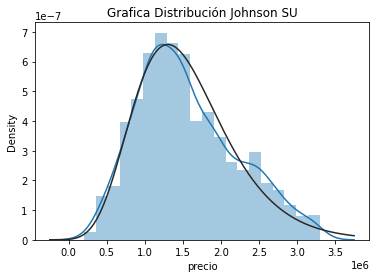

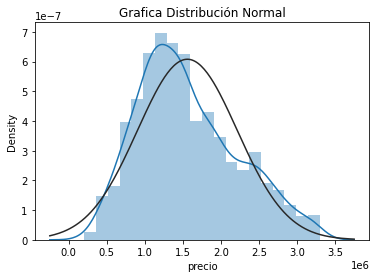

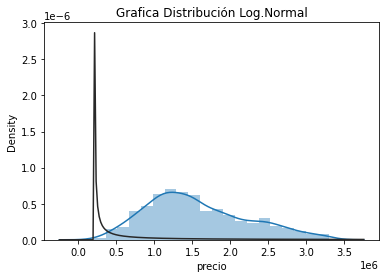

In [213]:
#Distribución de los datos cuantitativos. En este caso son la variable price (solo train), metros2 y año
import scipy.stats as st
plt.title('Grafica Distribución Johnson SU')
sns.distplot(train.precio , bins = 20, fit = st.johnsonsu)
plt.show()
plt.title('Grafica Distribución Normal')
sns.distplot(train.precio , bins = 20, fit = st.norm )
plt.show()
plt.title('Grafica Distribución Log.Normal')
sns.distplot(train.precio , bins = 20, fit = st.lognorm)
plt.show()

In [214]:
st.normaltest(train['precio'])
#This function tests the null hypothesis that a sample comes from a normal distribution.

NormaltestResult(statistic=77.33560483892975, pvalue=1.609855078247269e-17)

En este caso, se testea la distribución de la variable dependiente. En este caso, no sigue una distribución normal. Esto provoca una futura transformación de los datos para poder aplicar modelos de regresión.

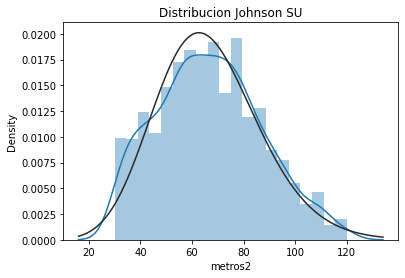

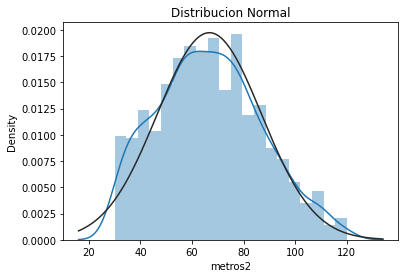

NormaltestResult(statistic=42.75527731988666, pvalue=5.197679468860227e-10)

In [215]:
plt.title('Distribucion Johnson SU')
sns.distplot(train.metros2 , bins = 20, fit = st.johnsonsu)
plt.show()
plt.title('Distribucion Normal')
sns.distplot(train.metros2 , bins = 20, fit = st.norm )
plt.show()
st.normaltest(train['metros2'])

La otra variable continua importante es los metros2. En este caso, pasa algo muy similar a la variable dependiente. Los datos no siguen una distribución normal, y por ende, deben ser transformadas para realizar la modelación.

In [216]:
#Se va a transformar la informacion de anyo. Esta variable tampoco sigue una distribución normal. 
train['year_'] = 2022 - train['anyo']

Información de datos cuantitativos.
En este caso, se sabe que la información de 'Sp' y 'Sm' se encuentran en la variable 'situacion'. Por ende, solo se deja dicha variable y se transforma utilizando la metodología de One-hot-encoding. 

In [217]:
try: 
    train.drop(['Sp', 'Sm'], axis = 1, inplace = True)
    train.drop(['anyo'], axis = 1, inplace = True)
except: 
    print('Ya se eliminaron las columnas o no se encuentran en el data set')

Graficacion de de las variables categoricas

<AxesSubplot:title={'center':'Box-Plot: Precio-Barrio'}, xlabel='precio', ylabel='situacion'>

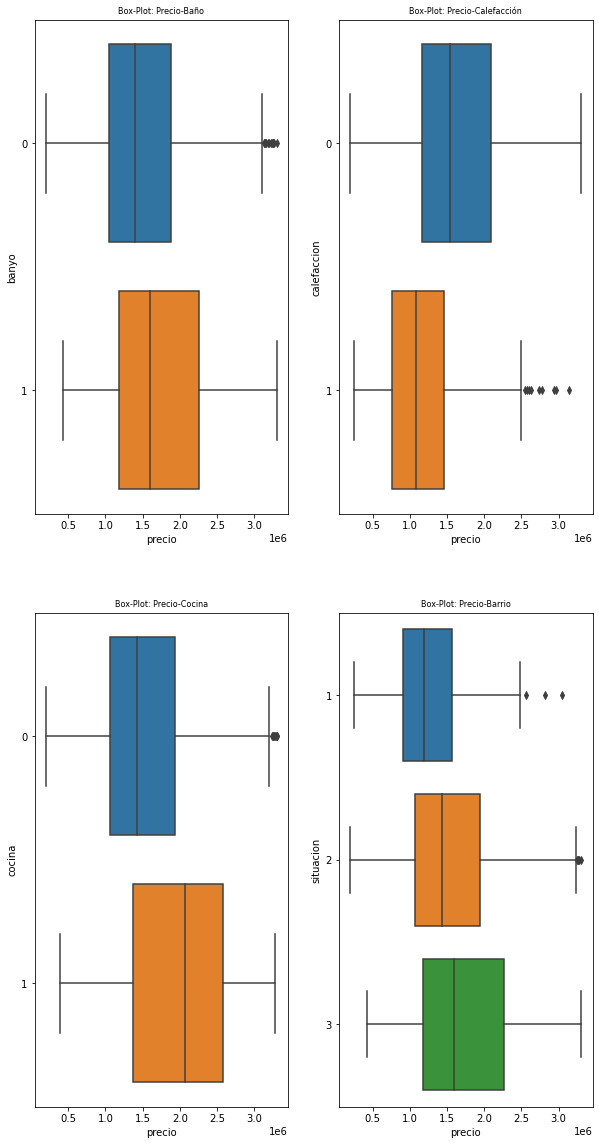

In [218]:
fig, axes = plt.subplots(nrows=2, ncols = 2, figsize = (10,20))
axes[0,0].set_title('Box-Plot: Precio-Baño', fontsize=8)
axes[0,1].set_title('Box-Plot: Precio-Calefacción',fontsize=8)
axes[1,0].set_title('Box-Plot: Precio-Cocina',fontsize=8)
axes[1,1].set_title('Box-Plot: Precio-Barrio',fontsize=8)
sns.boxplot(x = train['precio'], y = train['banyo'], orient = 'h', ax = axes[0,0])
sns.boxplot(x = train['precio'], y = train['calefaccion'], orient = 'h', ax = axes[0,1])
sns.boxplot(x = train['precio'], y = train['cocina'], orient = 'h', ax = axes[1,0])
sns.boxplot(x = train['precio'], y = train['situacion'], orient = 'h', ax = axes[1,1])

Estas gráficas muestran la relación que puede existir entre las variables discretas y la variable dependiente. Se observa que características como la calidad del baño y la cocina inciden en el precio del baño, tendiendo a tener un mayor precio. Sin embargo, hay valores mínimos y máximos que se salen de ese primer análisis. Para la variable de situación, podemos observar que inmuebles que se encuentran en un barrio superior a la media, tienden a tener un precio mayor en el canon de arrendamiento. Por último, en el caso de la calefacción se presenta un análisis peculiar. Las viviendas que poseen calefacción central tienden a tener un precio mayor. Esto se podría explicar por los mayores costos en los servicios que se pueden presentar por el uso de estos productos. 

In [219]:
train_one = pd.get_dummies(train, columns = ['situacion'])
train_one.head()

,precio,metros2,banyo,calefaccion,cocina,year_,situacion_1,situacion_2,situacion_3
0,1386600.0,50,0,0,0,20,0,1,0
1,844000.0,54,0,0,0,20,0,1,0
2,1473200.0,70,0,0,0,20,0,1,0
3,2590200.0,55,0,0,0,99,0,1,0
4,790000.0,46,0,1,0,35,0,1,0


Esta vez, se separa la variable categórica de la situación en 3 columnas. Teniendo en cuenta que los modelos no pueden recibir variables de categorías (Al menos los que utilizamos), se deben convertir en dummys para poder realizar el análisis.

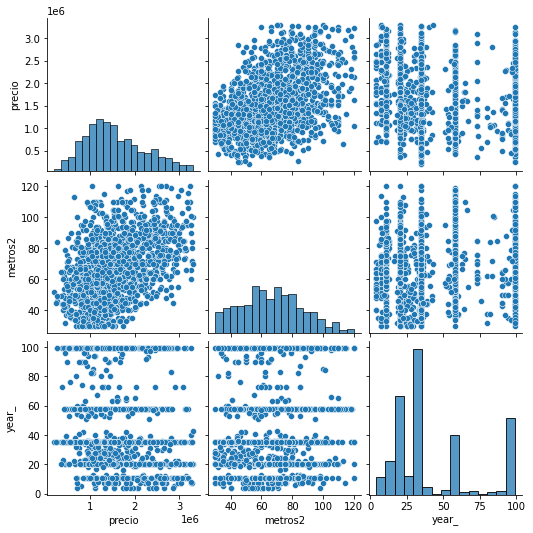

In [220]:
# Pair plot para mirar las relaciones de manera mas detallada
sns.pairplot(train_one[['precio', 'metros2', 'year_']])

Entre las variables continuas, se presenta una posible relación entre los precios y los metros 2. Sin embargo, se tiene la sensación que la relación entre los datos no tiende a ser del todo lineal.

####  Análisis de selección de características
En esta ocasión se va a desarrollar 3 metodologías de Feature Selection para decidir que atributos son relevantes para la modelación
   * Selección Univariante 
   * Feature Importance
   * Correlograma

In [221]:
xs  = [x for x in train_one.columns if x != 'precio']
y = np.array(train_one['precio'])
X = train_one[xs]

In [222]:
# Seleccion Univariante

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,train_size = 0.8 ,random_state=42)
X_train = np.array(X_train)
y_train = np.array(y_train).reshape(-1,1)
f_selector = SelectKBest(score_func=f_regression, k='all')

# learn relationship from training data
f_selector.fit(X_train, y_train)

# transform train input data
X_train_fs = f_selector.transform(X_train)

# transform test input data
X_test_fs = f_selector.transform(X_test)

# Data Frame con los resultados
results_df=pd.DataFrame(f_selector.scores_)
names=pd.DataFrame(X.columns)

#Concat and name columns
scored=pd.concat([names,results_df], axis=1)
scored.columns = ["Feature", "Score"]
scored.sort_values(by=['Score']).head(13)

,Feature,Score
6,situacion_2,6.162010
5,situacion_1,22.755268
1,banyo,32.280589
7,situacion_3,32.280589
4,year_,37.233711
3,cocina,48.659549
2,calefaccion,123.594903
0,metros2,297.042631


Este modelo aplica una función de correlación lineal entre las variables dependientes e independientes. En este caso, nos brinda información de las columnas con el score (F-value). Los valores elevados presentan una importancia mayor vista como una correlación lineal. Las variables 'metros2' y 'calefaccion' son importantes a la hora de aplicar el modelo de regresión.

In [223]:
#Feature Importance 
#Para este caso, vamos a utilizar un primer acercamiento a un modelo no parametrico para realizar esta decision 
#Se utiliza un Random Forest para llegar a saber cuales son los atributos mas importantes

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,train_size = 0.8 ,random_state=42)
X_train = np.array(X_train)
y_train = np.array(y_train).reshape(-1,1)
f_selector = SelectKBest(score_func=mutual_info_regression, k='all')

# learn relationship from training data
f_selector.fit(X_train, y_train)

# transform train input data
X_train_fs = f_selector.transform(X_train)

# transform test input data
X_test_fs = f_selector.transform(X_test)

# Data Frame con los resultados
results_df=pd.DataFrame(f_selector.scores_)
names=pd.DataFrame(X.columns)

#Concat and name columns
scored=pd.concat([names,results_df], axis=1)
scored.columns = ["Feature", "Score"]
scored.sort_values(by=['Score']).head(13)

,Feature,Score
6,situacion_2,0.006059
5,situacion_1,0.007167
3,cocina,0.014146
4,year_,0.017349
1,banyo,0.020644
7,situacion_3,0.020974
2,calefaccion,0.059091
0,metros2,0.126094


Este modelo realiza un análisis similar al anterior, pero en este caso, se implementa un modelo de relación no lineal denominado 'mutual information'. Los resultados son similares a los obtenidos con el f-regressio. Se analiza que la variable situacion_2 no brinda información importante para el análisis. Se propone eliminarla, por los posibles problemas de multicolinealidad que se pueden presentan. Sin embargo, como el principal problema es de predicción, este tipo de problemas se pueden pasar por alto. 

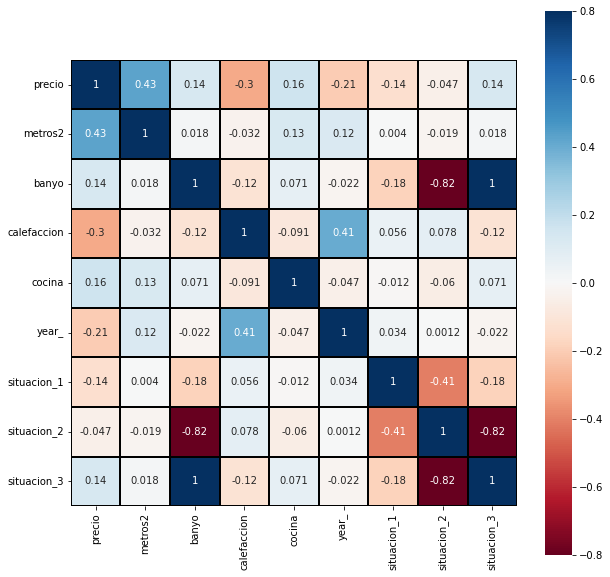

In [224]:
#Matriz de correlación. 

cor = train_one.corr(method='spearman')
#De manera grafica, se observa que en la mayoria de las distribucioines no se cumple 
#el suspuesto de normalidad
plt.figure(figsize = (10,10))
sns.heatmap(cor, vmax = 0.8, vmin = -0.8,linewidths=0.01, square = True, annot = True, cmap= "RdBu", linecolor = 'black');

En esta ocasión, se realiza un análisis gráfico. Como no se cumple el supuesto de normalidad, se utiliza la función de correlación se spearman. No hay presencia de correlación fuerte, pero, las variables de metros2 es la más relevante en este análisis. Con este gráfico, podemos observar una fuerte relación entre situacion_2, situacion_3 y banyo. Esto puede causar problemas a la hora de aplicar el modelo. En primera medida se elimina la variable situacion_2, la cual, fue la que menos importancia presento usando las 3 metodologías. Más adelante, se analiza que se puede realizar con las variables situacion_3 y banyo. 

Se presenta una fuerte relación entre tener un cuarto de baño y la calidad del barrio. Eso se puede deber a que la presencia de una residencia en un tipo de barrio ya define que las características del inmueble son mejores. 

In [225]:
try: 
    train_one.drop(['situacion_2'], axis = 1, inplace = True)
    #train_one.drop(['banyo'], axis = 1, inplace = True)
except: 
    print('Ya se eliminaron las columnas o no se encuentran en el data set')

#### Modelación
En este caso, se intentarán 3 metodologías. 
   * Implementación de un modelo de regresión lineal múltiple
   * Implementación de un modelo XGBoost 
   * Implementación de una red neuronal sencilla que me sirva para predecir con mayor exactitud. 
   
Para elegir la metodología indicada, se debe plantar el trade-off que se presenta al implementar cada una de ellas. La escala va desde un modelo más sencillo, pero con mayor interpretabilidad, y se termina con un modelo más robusto pero con la incapacidad de ser interpretable.

Antes que eso, se desea implementar un modelo no supervisado PCA para definir si puede se puede maximizar la varianza explicada utilizando 2 o más componentes. 

In [226]:
xs  = [x for x in train_one.columns if x != 'precio']
x = train_one[xs]
x = StandardScaler().fit_transform(x)

from sklearn.decomposition import PCA
pca = PCA(n_components= 2)
principalComponents = pca.fit_transform(x)
df_pca = pd.DataFrame(data = principalComponents
             , columns = ['PCA1', 'PCA2'])

<AxesSubplot:xlabel='PCA1', ylabel='PCA2'>

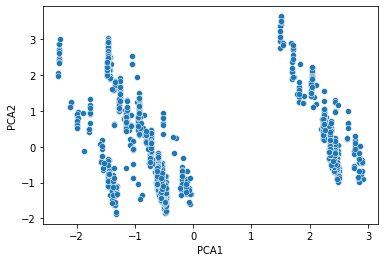

In [227]:
sns.scatterplot(x=df_pca.PCA1,y=df_pca.PCA2)

In [228]:
print('Dimension sin PCA: {}'.format(len(xs)))
pca.explained_variance_ratio_

Dimension sin PCA: 7


array([0.30358462, 0.20130921])

Se indagó la posibilidad de realizar una reducción de dimensionalidad. En este caso, se utilizaron 2 componentes que explican el 50% de la varianza. Eso puede causar una pérdida importante de información y se evita la utilización de esta metodología para el problema de regresión. Sin embargo, si se estuviera realizando un clúster de las casas de arrendamiento, podría ser útil para aplicar un modelo no supervisado de clustering. 

#### Modelo Paramétrico (Regularización)
Regresión Lasso y Ridge. Lasso tiene la capacidad de llevar los estimadores no relevantes a 0. Sin embargo, se intentan las 2.

In [229]:
from sklearn.linear_model import Ridge, RidgeCV,LassoCV, Lasso
from sklearn.model_selection import cross_val_score

In [230]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = 9))
    return(rmse)
# ShuffleSplit(n_splits=3, test_size=0.3)

In [231]:
#Tranformacion de los datos continuos usando log
train_one["precio2"] = np.log1p(train_one["precio"])
train_one['metros22'] = np.log1p(train_one['metros2'])

In [232]:
train_one.describe().T

,count,mean,std,min,25%,50%,75%,max
precio,1528.0,1.559455e+06,656265.845457,203400.000000,1.079700e+06,1.444600e+06,1.974000e+06,3.300000e+06
metros2,1528.0,6.671204e+01,20.228319,30.000000,5.200000e+01,6.600000e+01,8.000000e+01,1.200000e+02
banyo,1528.0,2.709424e-01,0.444592,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
calefaccion,1528.0,2.009162e-01,0.400817,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
cocina,1528.0,7.329843e-02,0.260711,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
year_,1528.0,4.330628e+01,28.837697,4.000000,2.000000e+01,3.500000e+01,5.800000e+01,9.900000e+01
situacion_1,1528.0,8.311518e-02,0.276147,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
situacion_3,1528.0,2.709424e-01,0.444592,0.000000,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
precio2,1528.0,1.416427e+01,0.454889,12.222935,1.389219e+01,1.418334e+01,1.449557e+01,1.500943e+01
metros22,1528.0,4.167914e+00,0.314770,3.433987,3.970292e+00,4.204693e+00,4.394449e+00,4.795791e+00


In [278]:
#Variables de entrenamiento y testeo
xs  = [x for x in train_one.columns if x != 'precio' and x != 'precio2' and x != 'metros2' and x != 'banyo']
X = train_one[xs]
y = train_one['precio2']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,train_size = 0.7 ,random_state=42)
X_train = np.array(X_train)
y_train = np.array(y_train).reshape(-1,1)

In [279]:
from sklearn import linear_model
lr = linear_model.LinearRegression()

In [280]:
lr.fit(X_train, y_train)

LinearRegression()

In [281]:
predictions = lr.predict(X_test)

In [282]:
print ('MAE is:', mean_absolute_error(y_test, predictions))
print ('MSE is:', mean_squared_error(y_test, predictions))
print ('RMSE is:', np.sqrt(mean_squared_error(y_test, predictions)))

MAE is: 0.3128786800732425
MSE is: 0.15881763883513486
RMSE is: 0.39851930798285656


Text(0.5, 1.0, 'Linear Regression Model')

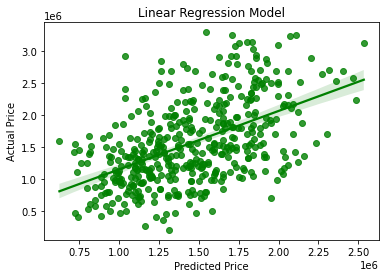

In [283]:
predictions = np.expm1(lr.predict(X_test))
y_test_exp = np.expm1(y_test)

sns.regplot(x = predictions, y = y_test_exp, color = 'g')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Linear Regression Model')

Utilizando el modelo más sencillo, encontramos una posible relación lineal entre los atributos del hogar y el precio de la residencia. Sin embargo, se presenta un RMSE considerablemente bajo, pero podría tener complicaciones al intentar predecir de manera exacta el valor del arrendamiento. Por ende, se implementan otras modelos lineales. Esta vez, de regularización.

In [284]:
from sklearn.model_selection import GridSearchCV
model = Ridge()
param_grid = { 'alpha': [0.05, 0.1, 0.3, 1, 3, 5,6,7,8,9]}
cv_ridge = GridSearchCV(estimator=model, param_grid=param_grid, cv= 5)

In [285]:
cv_ridge.fit(X_train, y_train)
pred = cv_ridge.predict(X_test)
cv_ridge.best_estimator_.get_params()

{'alpha': 1,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': 'deprecated',
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [286]:
print ('MAE is:', mean_absolute_error(y_test, pred))
print ('MSE is:', mean_squared_error(y_test, pred))
print ('RMSE is:', np.sqrt(mean_squared_error(y_test, pred)))

MAE is: 0.312836002425098
MSE is: 0.1586992505483397
RMSE is: 0.39837074509599685


Text(0.5, 1.0, 'Ridge Regression Model')

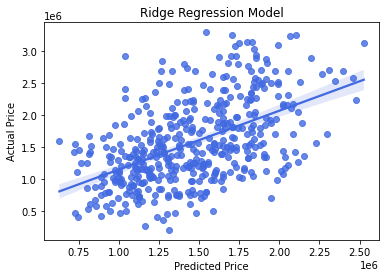

In [287]:
predictions = np.expm1(pred)
y_test_exp = np.expm1(y_test)

sns.regplot(x = predictions, y = y_test_exp, color = 'royalblue')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Ridge Regression Model')

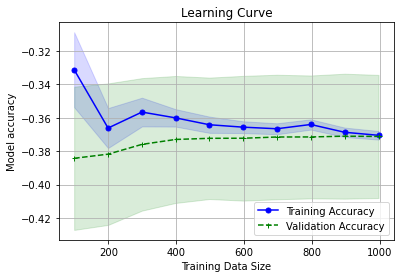

In [288]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(estimator=cv_ridge, X=X_train, y=y_train,
                                                       cv=15, train_sizes=np.linspace(0.1, 1.0, 10),
                                                     n_jobs=1, scoring='neg_root_mean_squared_error')
#
# Calculate training and test mean and std
#
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
#
# Plot the learning curve
#
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

In [289]:
#Ahora sigue el modelo Lasso
model = Lasso()
param_grid = { 'alpha': [0.05, 0.1, 0.3, 1, 3, 5,6,7,8,9]}
cv_rfc = GridSearchCV(estimator=model, param_grid=param_grid, cv= 10)

In [290]:
cv_rfc.fit(X_train, y_train)
pred = cv_rfc.predict(X_test)
cv_rfc.best_estimator_.get_params()

{'alpha': 0.05,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': 'deprecated',
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [291]:
print ('MAE is:', mean_absolute_error(y_test, pred))
print ('MSE is:', mean_squared_error(y_test, pred))
print ('RMSE is:', np.sqrt(mean_squared_error(y_test, pred)))

MAE is: 0.3429327489408303
MSE is: 0.18712720825460574
RMSE is: 0.43258202488615466


Text(0.5, 1.0, 'Lasso Regression Model')

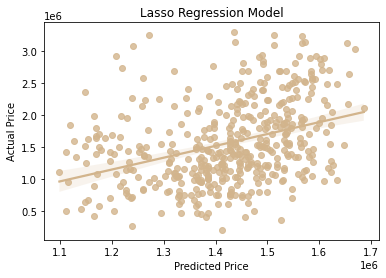

In [292]:
predictions = np.expm1(pred)
y_test_exp = np.expm1(y_test)

sns.regplot(x = predictions, y = y_test_exp, color = 'tan')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Lasso Regression Model')

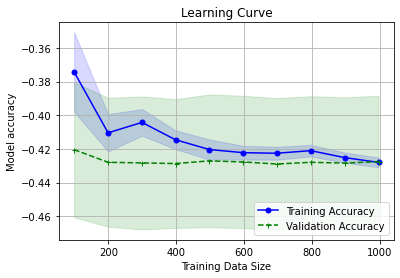

In [293]:
train_sizes, train_scores, test_scores = learning_curve(estimator=cv_rfc, X=X_train, y=y_train,
                                                       cv=15, train_sizes=np.linspace(0.1, 1.0, 10),
                                                     n_jobs=1, scoring='neg_root_mean_squared_error')
#
# Calculate training and test mean and std
#
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
#
# Plot the learning curve
#
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training Accuracy')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', marker='+', markersize=5, linestyle='--', label='Validation Accuracy')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title('Learning Curve')
plt.xlabel('Training Data Size')
plt.ylabel('Model accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.show()

Se realizaron 3 modelos de regresión. En este caso, los 3 dieron valores de error menos a 0.5. Definir si estas métricas son aceptables para el problema en cuestión. Los hyper paremetros de los modelos de regularización solo poseen un parámetro alpha, el cual es elegido mediante la implementación de un algoritmo de optimización llamado GridSearch. El mejor resultado es entregado por el modelo Ridge(). Este lanzó un RMSE de 0.388. Será tomado en cuenta para el testeo final.

#### Modelo de regresion XBGBoost


In [294]:
import xgboost as xgb

modelo = xgb.XGBRegressor()

parametros = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

grid = GridSearchCV(
    estimator=modelo,
    param_grid=parametros,
    scoring = 'neg_root_mean_squared_error',
    n_jobs = 2,
    cv = 10
)
grid.fit(X_train, y_train)

GridSearchCV(cv=10,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_ca...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                  

In [295]:
pred = grid.predict(X_test)
print ('MAE is:', mean_absolute_error(y_test, pred))
print ('MSE is:', mean_squared_error(y_test, pred))
print ('RMSE is:', np.sqrt(mean_squared_error(y_test, pred)))

MAE is: 0.30403691184714626
MSE is: 0.15233203223993277
RMSE is: 0.3902973638649546


Text(0.5, 1.0, 'Xgboost Regression Model')

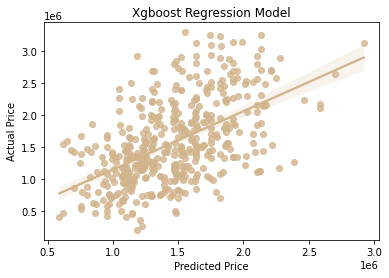

In [296]:
predictions = np.expm1(pred)
y_test_exp = np.expm1(y_test)

sns.regplot(x = predictions, y = y_test_exp, color = 'tan')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Xgboost Regression Model')

Se aplicó otro modelo para probas como se ajusta al modelo. XGBoost es un "gradient-boosted decision tree (GBDT)". Lo cual, en términos de eficiencia a la hora de aplicar modelos.

#### Red Neuronal
Para realizar la última comparación del modelo, se va a entrenar una red neural que permita predecir de una mejor manera los precios de los inmuebles. Tener cuidado a la hora de correr de nuevo estas celdas. Los resultados pueden variar.

In [519]:
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasRegressor

In [297]:
# X = trai
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,train_size = 0.8 ,random_state=42)
X_train.shape

(1069, 6)

In [565]:
oculta1 = tf.keras.layers.Dense(units=6, input_dim = 6 ,kernel_initializer='normal')
oculta2 = tf.keras.layers.Dense(units=6)#, activation = 'relu')#, activation = tf.nn.leaky_relu)
salida = tf.keras.layers.Dense(units=1)
modelo1 = tf.keras.Sequential([oculta1,oculta2,salida])


In [566]:
modelo1.compile(
    optimizer=tf.keras.optimizers.Adam(0.04),
    loss='mean_squared_error'
)

In [567]:
print("Comenzando entrenamiento...")
historial = modelo1.fit(X_train, y_train, epochs=500, verbose= False)
print("Modelo entrenado!")

Comenzando entrenamiento...
Modelo entrenado!


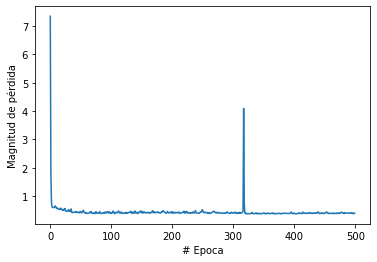

In [568]:
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(np.sqrt(historial.history["loss"]))

In [569]:
pred = modelo1.predict(X_test)
pred[:5]

array([[13.850211 ],
       [14.633011 ],
       [14.42971  ],
       [13.961506 ],
       [14.4906845]], dtype=float32)

In [570]:
print ('MAE is:', mean_absolute_error(y_test, pred))
print ('MSE is:', mean_squared_error(y_test, pred))
print ('RMSE is:', np.sqrt(mean_squared_error(y_test, pred)))

MAE is: 0.32265496410306305
MSE is: 0.177114837289444
RMSE is: 0.4208501363780746


Text(0.5, 1.0, 'Neural Network Regression Model')

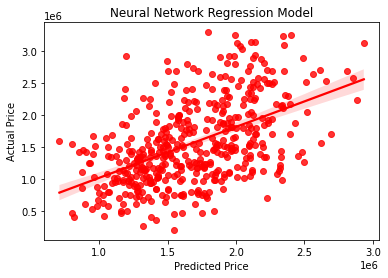

In [571]:
predictions = np.expm1(pred)
y_test_exp = np.expm1(y_test)

sns.regplot(x = predictions, y = y_test_exp, color = 'red')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Neural Network Regression Model')

#### Entrega de los resultados de test
Al final, los modelos que tuvieron un mejor resultado en el entrenamiento fueron XGBoost y Ridge. Por ende se va a decir entre estos 2. 

In [531]:
#Transformacion de los datos
#1. Año
#2. Eliminar las columnas que no sirven para el modelo. One hot encoding 
#3. Pasar a log la informacion de metros
def Transform(df): 
    try: 
         df.drop(['precio'], axis = 1, inplace = True)
    except:
        pass
    df['year_'] = 2022 - df['anyo']
    df = pd.get_dummies(df, columns = ['situacion'])
    df['metros22'] = np.log1p(df['metros2'])
    try: 
        df.drop(['Sp', 'Sm'], axis = 1, inplace = True)
        df.drop(['anyo'], axis = 1, inplace = True)
        df.drop(['situacion_2'], axis = 1, inplace = True)
        df.drop(['banyo'], axis = 1, inplace = True)
        df.drop(['metros2'], axis = 1, inplace = True)
    except: 
        print('Ya se eliminaron las columnas o no se encuentran en el data set')
    
    return df

test_one = Transform(test)
test_one.head(7)


,calefaccion,cocina,year_,situacion_1,situacion_3,metros22
0,0,0,20,0,0,3.931826
1,0,0,99,0,0,4.094345
2,0,0,20,0,0,3.526361
3,0,0,7,0,0,4.430817
4,0,0,20,0,0,4.543295
5,0,1,35,1,0,4.653960
6,1,0,81,0,0,3.713572


Text(0.5, 1.0, 'Comparación Resultados')

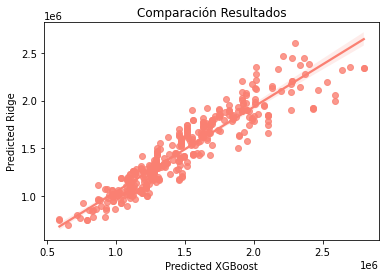

In [585]:
#Prediccion:
#En este caso, el mejor modelo fue la regresion regularizada Ridge con un RMSE = 0.3891
pred_boost = grid.predict(test_one)
pred_ridge = cv_ridge.predict(test_one)
predictions_boost = np.expm1(pred_boost)
predictions_ridge = np.expm1(pred_ridge)

sns.regplot(x = predictions_boost, y = predictions_ridge, color = 'salmon')
plt.xlabel('Predicted XGBoost')
plt.ylabel('Predicted Ridge')
plt.title('Comparación Resultados')

Se presenta que las predicciones son similares. Sin embargo, en los altos más altos se presenta una dispersión. Por temas de simplicidad, se escogerá el modelo de Ridge. Este posee una complejidad inferior y una mejor interpretabilidad.

In [586]:
test['precio'] = predictions_ridge
pred[:10]

array([14.110157, 14.055637, 13.990394, 14.559132, 14.450599, 14.37874 ,
       13.515843, 13.786742, 14.306726, 14.559132], dtype=float32)

In [587]:
test.describe()

,metros2,anyo,banyo,Sp,Sm,calefaccion,cocina,situacion,year_,precio
count,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,393.000000,3.930000e+02
mean,68.325700,1977.664122,0.287532,0.109415,0.025445,0.203562,0.078880,2.178117,44.335878,1.472746e+06
std,21.565651,29.218026,0.453189,0.312557,0.157674,0.403160,0.269896,0.605105,29.218026,3.934023e+05
min,30.000000,1923.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000,6.924205e+05
25%,52.000000,1964.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,20.000000,1.174783e+06
50%,68.000000,1987.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,35.000000,1.428705e+06
75%,83.000000,2002.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,58.000000,1.772904e+06
max,120.000000,2018.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,99.000000,2.602739e+06


In [588]:
test.to_csv('bd_test_evaluate.csv')

### Modelación Data no estructurada
Tarea 1: Web Scraping 

In [406]:
import requests
from bs4 import BeautifulSoup
r = requests.get('https://www.epdlp.com/texto.php?id2=557')
soup = BeautifulSoup(r.content, 'html.parser')
page_title = soup.title.text
page_body = soup.body
page_head = soup.head


In [412]:
import re
def Eliminar_html(text):
    html = re.compile(r"<.*?>|&([a-z0-9]+|#x[0-9a-f]{1,6});|#[0-9]{1,6};|\n|quot|\t|\r|")
    return re.sub(html, "", text)
l2 = Eliminar_html(str(page_body))

In [413]:
l2

'Cien años de soledad (fragmento)Gabriel García MárquezCien años de soledad (fragmento)Muchos años después, frente al pelotón de fusilamiento, el coronel Aureliano Buendía había de recordar aquella tarde remota en que su padre lo llevó a conocer el hielo. Macondo era entonces una aldea de veinte casas de barro y cañabrava construida a la orilla de un río de aguas diáfanas que se precipitaban por un lecho de piedras pulidas, blancas y enormes como huevos prehistóricos. El mundo era tan reciente, que muchas cosas carecían de nombre, y para mencionarlas había que señalarlas con el dedo. (...) José Arcadio Buendía, que era el hombre más emprendedor que se vería jamás en la aldea, había dispuesto de tal modo la posición de las casas, que desde todas podía llegarse al río y abastecerse de agua con igual esfuerzo, y trazó las calles con tan buen sentido que ninguna casa recibía más sol que otra a la hora del calor. En pocos años, Macondo fue una aldea más ordenada y laboriosa que cualquiera d

In [420]:
import collections
texto = str(l2)
acumulador = {}
for palabra in texto.upper().split():
    acumulador.setdefault(palabra, 0)
    acumulador[palabra] = acumulador[palabra] + 1

dicc = collections.Counter(acumulador)

In [421]:
print(dicc)

Counter({'DE': 25, 'Y': 19, 'EL': 18, 'LA': 15, 'EN': 12, 'QUE': 12, 'UN': 7, 'ERA': 6, 'UNA': 6, 'POR': 6, 'SOLEDAD': 5, 'A': 5, 'CON': 5, 'VIO': 5, 'LOS': 5, 'AÑOS': 4, 'HABÍA': 4, 'SE': 4, 'MÁS': 4, 'LAS': 4, 'DEL': 4, 'AL': 3, 'MACONDO': 3, 'ENTONCES': 3, 'ALDEA': 3, 'TAN': 3, 'FRENTE': 2, 'AURELIANO': 2, 'SU': 2, 'RÍO': 2, 'COMO': 2, '(...)': 2, 'CASA': 2, 'OTRA': 2, 'FUE': 2, 'HASTA': 2, 'DONDE': 2, 'NADIE': 2, 'NO': 2, 'QUEDÓ': 2, 'HORMIGAS': 2, 'PENSANDO': 2, 'CIRCO,': 2, 'DÓNDE': 2, 'AMOR': 2, 'CIEN': 1, '(FRAGMENTO)GABRIEL': 1, 'GARCÍA': 1, 'MÁRQUEZCIEN': 1, '(FRAGMENTO)MUCHOS': 1, 'DESPUÉS,': 1, 'PELOTÓN': 1, 'FUSILAMIENTO,': 1, 'CORONEL': 1, 'BUENDÍA': 1, 'RECORDAR': 1, 'AQUELLA': 1, 'TARDE': 1, 'REMOTA': 1, 'PADRE': 1, 'LO': 1, 'LLEVÓ': 1, 'CONOCER': 1, 'HIELO.': 1, 'VEINTE': 1, 'CASAS': 1, 'BARRO': 1, 'CAÑABRAVA': 1, 'CONSTRUIDA': 1, 'ORILLA': 1, 'AGUAS': 1, 'DIÁFANAS': 1, 'PRECIPITABAN': 1, 'LECHO': 1, 'PIEDRAS': 1, 'PULIDAS,': 1, 'BLANCAS': 1, 'ENORMES': 1, 'HUEVOS': 1,

Tareas 2: Escriba un programa que pida al usuario ingresar su correo electrónico y  devuelva por aparte el nombre del usuario y el nombre del dominio

In [3]:
def sin_tilde(string):
    replacements = (
    ("á", "a"),
    ("é", "e"),
    ("í", "i"),
    ("ó", "o"),
    ("ú", "u"),
    )
    for a, b in replacements:
        string = string.replace(a, b).replace(a.upper(), b.upper())
    
    return string

In [1]:
email = str(input('Ingrese su correo electronico: '))

Ingrese su correo electronico: aochoararanfo@gmail.com


In [4]:
def Separador_email(txt): 
    '''Funcion que separa la información de un email en dos partes. 
    El nombre del usuario y el domonio de la cuenta.
    Con esta funcion se realiza la separación pero no se valida si 
    el correo se encuentra bien diligenciado o no.'''
    import re
    
    if len(re.findall("@", txt)) > 1: 
        print('Hay un problema en su correo. Posee el caractér "@" mas de una vez. Esto no esta permitido. Volver a ingresar la información')
        return [None , None]
    
    else: 
        pattern = "[`~!#$%^&*()|+\=?;:',<>\{\}\[\]\\\/]"
        sep = txt.split('@')
        nombre = sin_tilde(sep[0])
        correo = sin_tilde(sep[1])
        lista = [nombre, correo]
        
        for i in lista: 
            if len( re.findall(pattern, i)) != 0:
                print('Se presenta un problema en el {} de la dirección. Tiene estos elementos prohibidos {}. Quitar eso caractéres.'.format(
                i,  re.findall(pattern, i)))
                return [None, None] 
            else: 
                pass
        
        if len(re.findall('[.]', correo)) == 0: 
            print('El dominio del correo no posee el signo ".", este elemento es fundamental. Favor colocarlo')
            return [None, None]
        else: 
            print('Se ha ingresado el correo correctamente')
            print('Su nombre de usuario es {} y el dominio del correo es {}'.format(nombre, correo))
            return [nombre , correo]
respuesta = Separador_email(email)

Se ha ingresado el correo correctamente
Su nombre de usuario es aochoararanfo y el dominio del correo es gmail.com
